# Aplicação de recomendação de alugueis

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

sns.set_theme(style="ticks")
plt.rcParams.update({
    'font.size': 12,          # Global font size
    'axes.labelsize': 20,     # Font size for x and y labels
    'axes.titlesize': 18,     # Font size for plot title
    'xtick.labelsize': 18,    # Font size for x-axis tick labels
    'ytick.labelsize': 18,     # Font size for y-axis tick labels
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'legend.fontsize': 14,
    'figure.figsize': (8, 6)
})


In [74]:
data = pd.read_csv(r'D:\Tech-Challenge-QuintoAndar\database\data_refined')
data.head()

,area,quartos,suite,banheiros,vagas,pet,mobiliado,metro_proximo,Aluguel,Condomínio,IPTU,Seguro incêndio,Taxa de serviço,Total,neighborhood,score
0,25.0,1.0,1,1.0,0.0,0,1,1,3500,550.0,0,45.0,90.0,4185,brooklin,167.400000
1,116.0,3.0,2,3.0,2.0,1,1,1,10000,1300.0,0,127.0,259.0,11686,brooklin,100.741379
2,28.0,1.0,1,1.0,0.0,0,1,1,2950,760.0,0,38.0,76.0,3824,brooklin,136.571429
3,26.0,1.0,0,1.0,0.0,1,0,1,2700,550.0,1,35.0,69.0,3355,brooklin,129.038462
4,32.0,1.0,0,1.0,1.0,0,1,1,3680,600.0,100,47.0,95.0,4522,brooklin,141.312500


In [75]:
# --------------- FEATURES ---------------
num_cols = [
    "area","quartos","suite","banheiros","vagas",
    "pet","mobiliado","metro_proximo",
    "Aluguel","Condomínio","IPTU","Seguro incêndio","Taxa de serviço","Total"
]
cat_cols = ["neighborhood"]  # one-hot

# X for ML (exclude 'score' if you use it later for ranking)
X = data[num_cols + cat_cols].copy()


In [76]:
numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    # keep 90% variance; or set an integer like n_components=5
    ("pca", PCA(n_components=0.90, svd_solver="full"))
])

categorical_pipe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

# Fit the preprocessor once (on all your cleaned data)
Z = preprocessor.fit_transform(X)  # Z is the transformed feature matrix ready for clustering


In [77]:
pca = preprocessor.named_transformers_["num"].named_steps["pca"]
print("Numeric PCA components kept:", pca.n_components_)
print("Explained variance ratio (numeric block):", pca.explained_variance_ratio_)
print("Cumulative:", pca.explained_variance_ratio_.cumsum()[-1])

Numeric PCA components kept: 7
Explained variance ratio (numeric block): [0.54699948 0.13334138 0.07145913 0.05387684 0.04895073 0.03926744
 0.03353308]
Cumulative: 0.9274280798521705


Definição de inercia: Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided (ref: documentação scikit-learn).

In [84]:
inertia = []

for k in range(2,31):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(Z)
    labels = km.fit_predict(Z)
    inertia.append(km.inertia_)


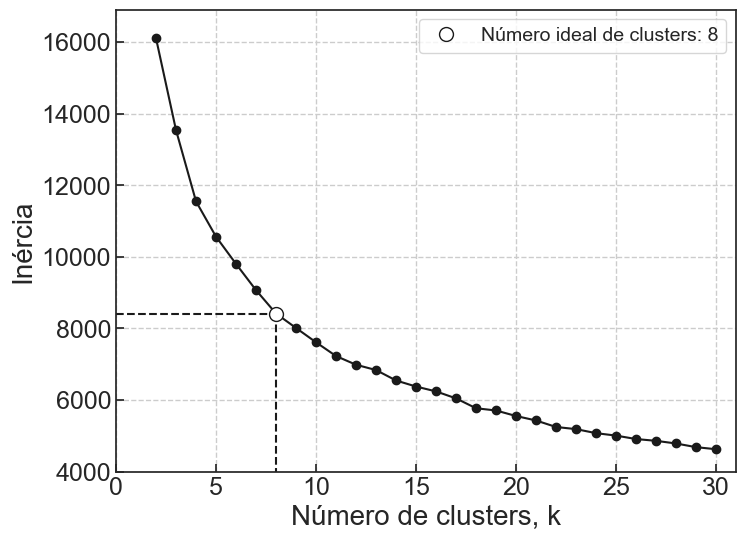

In [85]:

plt.plot(range(2,31), inertia,'ko-')
plt.plot([0,8],[inertia[6],inertia[6]], ls='--', c='k')
plt.plot([8,8],[0,inertia[6]], ls='--', c='k')
plt.plot(8, inertia[6], 'ko', ms=10, mfc='w', label=f'Número ideal de clusters: 8')
plt.xlabel('Número de clusters, k')
plt.ylabel('Inércia')
plt.ylim(bottom=4000)
plt.xlim(0,31)
plt.grid(True, ls='--')
plt.legend()
plt.show()

Por ora, vamos adotar o número de clusters como sendo k=8

In [86]:
kmeans_k = 8  

clustering_pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("kmeans", KMeans(n_clusters=kmeans_k, random_state=420, n_init=10))
])

# Fit on ALL cleaned data (global segmentation)
clustering_pipeline.fit(X)

# Labels for each listing
cluster_labels = clustering_pipeline.named_steps["kmeans"].labels_
data_refined = data.copy()
data_refined["cluster"] = cluster_labels

# (Optional) Inspect cluster sizes
print(data_refined["cluster"].value_counts())


cluster
3    362
1    355
6    348
4    299
5    242
7    109
2     63
0     31
Name: count, dtype: int64
